In [134]:
import os
from collections import Counter
try:
    import xml.etree.cElementTree as ET
except ImportError:
    import xml.etree.ElementTree as ET
import numpy as np
from scipy import sparse, stats
import pandas as pd
import pickle
import io
from sknn.mlp import Classifier, Layer
from sklearn import cross_validation, preprocessing, grid_search, metrics
from matplotlib import pyplot as plt

import util

%matplotlib inline

## Feature Extraction

In [2]:
TRAIN_DIR = "train"
TEST_DIR = "test"

call_set = pickle.load(open( "call_set.p", "rb" ))

In [ ]:
call_set_nonredundant = set(call_set) - set(["processes", "all_section"])

In [ ]:
#
def add_to_set(tree):
    for el in tree.iter():
        call = el.tag
        call_set.add(call)

def create_data_matrix(start_index, end_index, direc="train"):
    X = None
    classes = []
    ids = [] 
    i = -1
    for datafile in os.listdir(direc):
        if datafile == '.DS_Store':
            continue

        i += 1
        if i < start_index:
            continue 
        if i >= end_index:
            break

        # extract id and true class (if available) from filename
        id_str, clazz = datafile.split('.')[:2]
        ids.append(id_str)
        # add target class if this is training data
        try:
            classes.append(util.malware_classes.index(clazz))

        except ValueError:
            # we should only fail to find the label in our list of malware classes
            # if this is test data, which always has an "X" label
            assert clazz == "X"
            classes.append(-1)

        # parse file as an xml document
        tree = ET.parse(os.path.join(direc,datafile))
        # add_to_set(tree)
        this_row = call_feats(tree)
        if X is None:
            X = this_row 
        else:
            X = np.vstack((X, this_row))

    return X, np.array(classes), ids

def call_feats(tree):
    good_calls = list(call_set_nonredundant)
    call_counter = {}
    total_calls = 0
    n_success, success_denom = 0.0,0.0
    for el in tree.iter():
        call = el.tag
        if el.attrib.has_key('successful'):
            success_denom += 1
            n_success += int(el.attrib['successful'])
        total_calls += 1
        if call not in call_counter:
            call_counter[call] = 1
        else:
            call_counter[call] += 1
    unq_calls = len(call_counter.keys())
    percentage_success = n_success / success_denom
            
    call_feat_array = np.zeros(len(good_calls))
    for i in range(len(good_calls)):
        call = good_calls[i]
        call_feat_array[i] = 0
        if call in call_counter:
            call_feat_array[i] = call_counter[call]
    #print total_calls, unq_calls, percentage_success, success_denom, n_success
    call_feat_array = np.append(call_feat_array, [total_calls, unq_calls, percentage_success])
    
    return call_feat_array

In [ ]:
## Feature extraction
def main():
    # SAVE TRAINING DATA
    X_train, t_train, train_ids = create_data_matrix(0, 3086, direc=TRAIN_DIR)
    X_train = pd.DataFrame(X_train)
    t_train = pd.DataFrame(t_train, columns=['class'])
    train_ids = pd.DataFrame(train_ids,columns=['id'])
          
    filename1 = 'X_train.p'
    filename2 = 't_train.p'
    filename3 = 'train_ids.p'
    
    pickle.dump(X_train, io.open(filename1, 'wb'))
    pickle.dump(t_train, io.open(filename2, 'wb'))
    pickle.dump(train_ids, io.open(filename3, 'wb'))
    
    # SAVE TESTING DATA
    X_test, t_test, test_ids = create_data_matrix(0, 3724, direc=TEST_DIR)
    X_test = pd.DataFrame(X_test)
    test_ids = pd.DataFrame(test_ids,columns=['id'])
    
    filename4 = 'X_test.p'
    filename5 = 't_test.p'
    filename6 = 'test_ids.p'
    
    pickle.dump(X_test, io.open(filename4, 'wb'))
    pickle.dump(t_test, io.open(filename5, 'wb'))
    pickle.dump(test_ids, io.open(filename6, 'wb'))

In [ ]:
if __name__ == "__main__":
    main()

## Data Modeling

In [3]:
X_train = pickle.load(open( "X_train.p", "rb" ))
t_train = pickle.load(open( "t_train.p", "rb" ))
train_ids = pickle.load(open( "train_ids.p", "rb" ))

X_test = pickle.load(open("X_test.p", "rb"))
t_test = pickle.load(open( "t_test.p", "rb" ))
test_ids = pickle.load(open( "test_ids.p", "rb" ))

In [23]:
# first standardize data so NN converges
standardizer = preprocessing.StandardScaler().fit(X_train)

1010     CudaNdarray * indices = NULL;
1006     //TODO: if not a numpy.ndarray, convert to numpy.ndarray
1007     //TODO: If a CudaNdarray, accept it and suppose the data is int32? is float32 number of int?
1011     if (CudaNdarray_Check(indices_obj)) {
1007     //TODO: If a CudaNdarray, accept it and suppose the data is int32? is float32 number of int?
1008     //TODO: Support ndarray of other dtype then int32
1012         if (verbose) printf("cudandarray indices\n");
1008     //TODO: Support ndarray of other dtype then int32
1009     //TODO: support list of indices that are not c_contiguous
1013         indices = (CudaNdarray*) indices_obj;
1009     //TODO: support list of indices that are not c_contiguous
1010     CudaNdarray * indices = NULL;
1014         Py_INCREF(indices);
1010     CudaNdarray * indices = NULL;
1011     if (CudaNdarray_Check(indices_obj)) {
1015     } else if (0 && PyArray_Check(indices_obj)) {
1011     if (CudaNdarray_Check(indices_obj)) {
1012         if (verbo

In [ ]:
params_2layers = {
    'hidden0__units': [36,72,108],
    'hidden0__type': ["Rectifier", "Sigmoid"],
    'hidden1__units': [36,72,108],
    'hidden1__type': ["Rectifier", "Sigmoid"],
    'weight_decay':[0.001,0.01,0.1,0.3],
}

nn2 = Classifier(
    layers = [
        Layer("Rectifier", units=72),
        Layer("Rectifier", units=72),
        Layer("Rectifier", units=72),
        Layer("Softmax"),
    ],
    learning_rate = 0.001,
    n_iter = 125,
)

rs2 = grid_search.GridSearchCV(nn2, params_2layers, cv = 3,n_jobs=1)

if __name__ == "__main__":
    rs2.fit(standardizer.transform(np.array(X_train)),np.array(t_train).flatten())

In [24]:
# define callbacks to measure epoch validation set accuracy
def custom_callback(event, **variables):
    print event, type(event)
    print variables

nn_rectifier = Classifier(
    layers = [
        Layer("Rectifier", units = 72),
        Layer("Rectifier", units = 72),
        Layer("Rectifier", units = 72),
        Layer("Softmax"),
    ],
    learning_rate = 0.001,
    n_iter = 100,
)
#nn_test.fit(standardizer.transform(X_train),np.array(t_train).flatten())

1177     }
1181         // We take 0 elements, so no need for the rest of the code.
1177     }
1178 
1182         // This speed up that case AND fix crash otherwise.
1178 
1179     dim3 n_blocks(std::min(CudaNdarray_HOST_DIMS(out)[0],65535),1,1);
1183         free(dims);
1179     dim3 n_blocks(std::min(CudaNdarray_HOST_DIMS(out)[0],65535),1,1);
1180     if(CudaNdarray_HOST_DIMS(out)[0] == 0){
1184         Py_DECREF(indices);
1180     if(CudaNdarray_HOST_DIMS(out)[0] == 0){
1181         // We take 0 elements, so no need for the rest of the code.
1185         return (PyObject *)out;
1181         // We take 0 elements, so no need for the rest of the code.
1182         // This speed up that case AND fix crash otherwise.
1186     }
1182         // This speed up that case AND fix crash otherwise.
1183         free(dims);
1187 
1183         free(dims);
1184         Py_DECREF(indices);
1188     switch (self->nd) {
1184         Py_DECREF(indices);
1185         return (PyObject *)out;
1189      

In [32]:
rectifier_no_reg = cross_validation.cross_val_score(nn_test,standardizer.transform(X_train),np.array(t_train).flatten(), cv=3)

In [82]:
rectifier_no_reg.std()

0.0090828938569408584

In [28]:
nn_sigmoid = Classifier(
    layers = [
        Layer("Sigmoid", units = 72),
        Layer("Sigmoid", units = 72),
        Layer("Sigmoid", units = 72),
        Layer("Softmax"),
    ],
    learning_rate = 0.001,
    n_iter = 100,
)
#nn_test.fit(standardizer.transform(X_train),np.array(t_train).flatten())

In [29]:
sigmoid_no_regularization = cross_validation.cross_val_score(nn_sigmoid,standardizer.transform(X_train),np.array(t_train).flatten(), cv=3)

In [83]:
nn_rectifier_dropout = Classifier(
    layers = [
        Layer("Rectifier", units = 72),
        Layer("Rectifier", units = 72),
        Layer("Rectifier", units = 72),
        Layer("Softmax"),
    ],
    learning_rate = 0.001,
    n_iter = 100,
    dropout_rate = 0.125
)
rectifier_dropout = cross_validation.cross_val_score(nn_rectifier_dropout,standardizer.transform(X_train),np.array(t_train).flatten(), cv=5)

In [84]:
nn_rectifier_dropout2 = Classifier(
    layers = [
        Layer("Rectifier", units = 72),
        Layer("Rectifier", units = 72),
        Layer("Rectifier", units = 72),
        Layer("Softmax"),
    ],
    learning_rate = 0.001,
    n_iter = 100,
    dropout_rate = 0.25
)
rectifier_dropout2 = cross_validation.cross_val_score(nn_rectifier_dropout2,standardizer.transform(X_train),np.array(t_train).flatten(), cv=5)

In [85]:
nn_rectifier_dropout3 = Classifier(
    layers = [
        Layer("Rectifier", units = 72),
        Layer("Rectifier", units = 72),
        Layer("Rectifier", units = 72),
        Layer("Softmax"),
    ],
    learning_rate = 0.001,
    n_iter = 100,
    dropout_rate = 0.30
)
rectifier_dropout3 = cross_validation.cross_val_score(nn_rectifier_dropout3,standardizer.transform(X_train),np.array(t_train).flatten(), cv=5)

In [86]:
nn_rectifier_dropout4 = Classifier(
    layers = [
        Layer("Rectifier", units = 72),
        Layer("Rectifier", units = 72),
        Layer("Rectifier", units = 72),
        Layer("Softmax"),
    ],
    learning_rate = 0.001,
    n_iter = 100,
    dropout_rate = 0.40
)
rectifier_dropout4 = cross_validation.cross_val_score(nn_rectifier_dropout4,standardizer.transform(X_train),np.array(t_train).flatten(), cv=5)

In [81]:
nn_rectifier_reg = Classifier(
    layers = [
        Layer("Rectifier", units = 72),
        Layer("Rectifier", units = 72),
        Layer("Rectifier", units = 72),
        Layer("Softmax"),
    ],
    learning_rate = 0.001,
    n_iter = 100,
    regularize = 'L2',
    weight_decay = 0.001
)
rectifier_reg = cross_validation.cross_val_score(nn_rectifier_reg,standardizer.transform(X_train),np.array(t_train).flatten(), cv=5)

In [78]:
nn_rectifier_reg1 = Classifier(
    layers = [
        Layer("Rectifier", units = 72),
        Layer("Rectifier", units = 72),
        Layer("Rectifier", units = 72),
        Layer("Softmax"),
    ],
    learning_rate = 0.001,
    n_iter = 100,
    regularize = 'L2',
    weight_decay = 0.01
)
rectifier_reg1 = cross_validation.cross_val_score(nn_rectifier_reg1,standardizer.transform(X_train),np.array(t_train).flatten(), cv=5)

In [79]:
nn_rectifier_reg2 = Classifier(
    layers = [
        Layer("Rectifier", units = 72),
        Layer("Rectifier", units = 72),
        Layer("Rectifier", units = 72),
        Layer("Softmax"),
    ],
    learning_rate = 0.001,
    n_iter = 100,
    regularize = 'L2',
    weight_decay = 0.1
)
rectifier_reg2 = cross_validation.cross_val_score(nn_rectifier_reg2,standardizer.transform(X_train),np.array(t_train).flatten(), cv=5)

In [80]:
nn_rectifier_reg3 = Classifier(
    layers = [
        Layer("Rectifier", units = 72),
        Layer("Rectifier", units = 72),
        Layer("Rectifier", units = 72),
        Layer("Softmax"),
    ],
    learning_rate = 0.001,
    n_iter = 100,
    regularize = 'L2',
    weight_decay = 0.2
)
rectifier_reg3 = cross_validation.cross_val_score(nn_rectifier_reg3,standardizer.transform(X_train),np.array(t_train).flatten(), cv=5)

In [117]:
nn_rectifier_reg4 = Classifier(
    layers = [
        Layer("Rectifier", units = 72),
        Layer("Rectifier", units = 72),
        Layer("Rectifier", units = 72),
        Layer("Softmax"),
    ],
    learning_rate = 0.001,
    n_iter = 100,
    regularize = 'L2',
    weight_decay = 0.45
)
rectifier_reg4 = cross_validation.cross_val_score(nn_rectifier_reg4,standardizer.transform(X_train),np.array(t_train).flatten(), cv=5)

In [129]:
print rectifier_reg.std(), rectifier_reg1.std(), rectifier_reg2.std(), rectifier_reg3.std()

0.0112245817768 0.00883197153144 0.0155815002353 0.0108662575721


In [ ]:
preds = nn.predict(standardizer.transform(X_test))
preds_write = preds.flatten()
util.write_predictions(preds_write, np.array(test_ids).flatten(), "2-layer-rectifier-NN.csv")

In [122]:
reg_x = [0,0.001,0.01,0.1,0.2,0.45]
reg_y_mean = [rectifier_no_reg.mean(),rectifier_reg.mean(), rectifier_reg1.mean(), rectifier_reg2.mean(), rectifier_reg3.mean(), rectifier_reg4.mean()]
reg_y_std = [rectifier_no_reg.std(),rectifier_reg.std(), rectifier_reg1.std(), rectifier_reg2.std(), rectifier_reg3.std(), rectifier_reg4.std()]
dropout_mean = [rectifier_no_reg.mean(),rectifier_dropout.mean(), rectifier_dropout2.mean(), rectifier_dropout3.mean(), rectifier_dropout4.mean()]
dropout_std = [rectifier_no_reg.std(),rectifier_dropout.std(), rectifier_dropout2.std(), rectifier_dropout3.std(), rectifier_dropout4.std()]
dropout_x = [0,0.125,0.25,0.3,0.4]

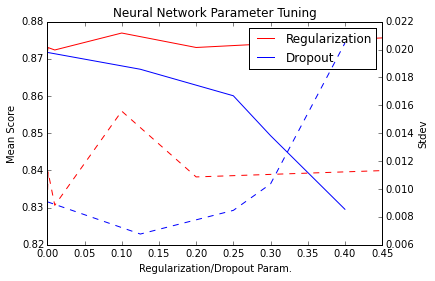

In [153]:

fig, ax1 = plt.subplots()

# plot means
ax1.plot(reg_x,reg_y_mean, "r-", label="Regularization")
ax1.plot(dropout_x,dropout_mean, "b-", label="Dropout")
ax1.set_xlabel("Regularization/Dropout Param.")
ax1.set_ylabel("Mean Score")

# plot
ax2 = ax1.twinx()
ax2.plot(reg_x, reg_y_std, "r--", label="Reg. Std")
ax2.plot(dropout_x, dropout_std, "b--", label="Dropout Std")
ax2.set_ylabel("Stdev")
ax1.set_title("Neural Network Parameter Tuning")
ax1.legend()

In [144]:
nn_rectifier_submit = Classifier(
    layers = [
        Layer("Rectifier", units = 72),
        Layer("Rectifier", units = 72),
        Layer("Rectifier", units = 72),
        Layer("Softmax"),
    ],
    learning_rate = 0.001,
    n_iter = 500,
    regularize = 'L2',
    weight_decay = 0.1
    )
nn_rectifier_submit.fit(standardizer.transform(X_train),np.array(t_train).flatten())

Classifier(batch_size=1, callback=None, debug=False, dropout_rate=None,
      f_stable=0.001,
      hidden0=<sknn.nn.Layer `Rectifier`: units=72, name=u'hidden0', frozen=False>,
      hidden1=<sknn.nn.Layer `Rectifier`: units=72, name=u'hidden1', frozen=False>,
      hidden2=<sknn.nn.Layer `Rectifier`: units=72, name=u'hidden2', frozen=False>,
      layers=[<sknn.nn.Layer `Rectifier`: units=72, name=u'hidden0', frozen=False>, <sknn.nn.Layer `Rectifier`: units=72, name=u'hidden1', frozen=False>, <sknn.nn.Layer `Rectifier`: units=72, name=u'hidden2', frozen=False>, <sknn.nn.Layer `Softmax`: units=15, name=u'output', frozen=False>],
      learning_momentum=0.9, learning_rate=0.001, learning_rule=u'sgd',
      loss_type=None, n_iter=500, n_stable=10,
      output=<sknn.nn.Layer `Softmax`: units=15, name=u'output', frozen=False>,
      random_state=None, regularize='L2', valid_set=None, valid_size=0.0,
      verbose=None, warning=None, weight_decay=0.1, weights=None)

In [145]:
preds_nn_submit = nn_rectifier_submit.predict(standardizer.transform(X_train))

In [146]:
print metrics.confusion_matrix(t_train,preds_nn_submit)
print metrics.accuracy_score(t_train,preds_nn_submit), metrics.precision_score(t_train,preds_nn_submit)


[[  92    0    1    0    0    0    0    1   18    0    0    0    2    0
     0]
 [   0   44    0    0    0    0    0    0    1    1    0    0    4    0
     0]
 [   0    0   31    0    0    2    0    0    4    0    0    0    0    0
     0]
 [   0    0    0   30    0    1    0    0    1    0    0    0    0    0
     0]
 [   0    0    0    0   37    0    0    0    4    0    0    0    0    0
     0]
 [   0    0    0    0    0   37    0    0    2    0    0    0    0    0
     0]
 [   0    0    0    0    0    0   53    0    0    0    0    0    0    0
     0]
 [   0    0    0    0    0    0    0   40    1    0    0    0    0    0
     0]
 [   3    0    0    0    0    0    0    0 1598    0    2    2    4    0
     0]
 [   0    0    0    0    0    0    0    0   10   11    0    0    0    0
     0]
 [   0    0    0    0    0    0    0    0    1    0  541    0    0    0
     0]
 [   0    0    0    0    0    0    0    0    5    0    0   27    0    0
     0]
 [   0    0    0    0    0    0    0    

/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


In [147]:
preds_nn_kaggle = nn_rectifier_submit.predict(standardizer.transform(X_test))

In [148]:
util.write_predictions(preds_nn_kaggle, np.array(test_ids).flatten(), "3-layer-rectifier-NN.csv")